# Toxic Comment Classification Challenge

This is for : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

This python notebook uses the tutorial from the book : Deep Learning with Python

Data files required can be downloaded from here: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

Download and save the data in ./data/ folder

# Data Analysis
1. Read ./data/train.csv file
2. Counts no. of training data per class
3. A single comment can belong to multiple class


In [8]:
import csv

toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

labels_count = {'toxic' : 0,
                'severe_toxic' : 0,
                'obscene' : 0,
                'threat' : 0,
                'insult' : 0,
                'identity_hate' : 0,
                'non_toxic' : 0}

with open('./data/train.csv') as train_file:
    reader = csv.DictReader(train_file)
    total_row = 0
    for row in reader:
        total_row += 1
        is_none = True
        for label in toxic_labels:
            if(row[label] == '1'):
                labels_count[label] += 1
                is_none = False
        if(is_none):
            labels_count['non_toxic'] += 1
    print(labels_count)
    print(total_row)

{'toxic': 15294, 'severe_toxic': 1595, 'obscene': 8449, 'threat': 478, 'insult': 7877, 'identity_hate': 1405, 'non_toxic': 143346}
159571


<BarContainer object of 7 artists>

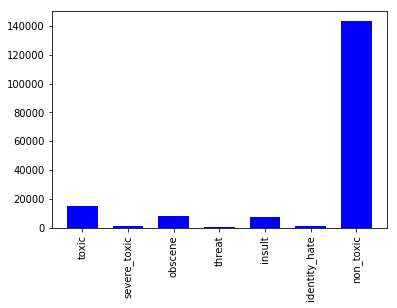

In [10]:
import matplotlib.pyplot as plt
plt.xticks(rotation=90)
plt.bar(labels_count.keys(), labels_count.values(), 1/1.5, color='b')


From above analysis we see that:
1. Total no. of training/validation data = 159,571
2. Total non-toxic comments = 143,346 (89.83%)
3. Rest 10.17% of commets has one of the toxic label
4. Some of labels like threat, identity_hate, severe_toxic has very less samples compared to other labels

So data per class is highly imbalanced

# Model 1 (Basic)
1. Each comment belongs to only 1 class other than 'toxic' class
2. Deep learning network has following layer:  
 2.1 Embedding Layer (populated using GloVe model)  
 2.2 LSTM Layer  
 2.3 Dense Layer to classes
 
This is a basic solution for the simplified version of the problem.

## Processing the raw data
### Create dataset for the network

In [11]:
texts = []
labels = []
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic_labels_id_map = {
    'non_toxic' : 0,
    'toxic' : 1,
    'severe_toxic' : 2,
    'obscene' : 3,
    'threat' : 4,
    'insult' : 5,
    'identity_hate' : 6
    }

num_rows_texts = 0
num_rows_labels = 0
with open('./data/train.csv') as train_file:
    reader = csv.DictReader(train_file)
    for row in reader:
        prev_row_count = num_rows_labels
        num_rows_texts += 1
        texts.append(row['comment_text'])
        is_none = True
        # check for labels other than toxic (1st label)
        for label in toxic_labels[1:]:
            if(row[label] == '1'):
                num_rows_labels += 1
                labels.append(toxic_labels_id_map[label])
                is_none = False
                break # a comments can have multiple labels but for now just take the 1st label <-- need to fix it
        if(is_none):
            num_rows_labels += 1
            # finally check if it is toxic or non-toxic
            if(row['toxic'] == '1'):
                labels.append(toxic_labels_id_map['toxic'])
            else:
                labels.append(toxic_labels_id_map['non_toxic'])
        if((num_rows_texts - num_rows_labels) < 0):
            print(row)
            break;

print(num_rows_texts)
print(num_rows_labels)

159571
159571


In [12]:
print('labels size:', len(labels))
labels[1:10]

labels size: 159571


[0, 0, 0, 0, 0, 2, 0, 0, 0]

### encoding the data: 
as it is multi class classification problem, the label need to be encoded into one hot encoding layer

In [13]:
from keras.utils.np_utils import to_categorical
one_hot_labels = to_categorical(labels)

Using TensorFlow backend.
/home/ravi/code/virtualenvs/keraskaggle/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [14]:
print(len(one_hot_labels))
print(one_hot_labels[6])

159571
[ 0.  0.  1.  0.  0.  0.  0.]


# Tokenizing the data

Splitting the comments in to tokens, later used to create word vectors

In [15]:
from keras.preprocessing.text import Tokenizer

max_words = 10000 # consider only the tops 10,000 words in dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokes.' % len(word_index))


Found 210337 unique tokes.


### pad/truncate all comments to a fixed length
ToDo: do this padding per batch

In [16]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100 # cuts of comments after 100 words
data = pad_sequences(sequences, maxlen=maxlen)
one_hot_labels = np.asarray(one_hot_labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', one_hot_labels.shape)

Shape of data tensor: (159571, 100)
Shape of label tensor: (159571, 7)


## Split Data
#### Split the data into training data and validation data
#### Data can be shuffled (optional)

In [17]:
training_samples = 120000 # trains on 120,000 samples
validation_samples = 39571 # validates on 39,571 samples (rest)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
one_hot_labels = one_hot_labels[indices]
one_hot_labels = one_hot_labels[indices]

x_train = data[:training_samples]
y_train = one_hot_labels[:training_samples]

x_val = data[training_samples : training_samples + validation_samples]
y_val = one_hot_labels[training_samples : training_samples + validation_samples]

### GloVe (Global Vector) Word Embedding setup
download the glove precomputed imbedding from: https://nlp.stanford.edu/projects/glove
unzip it
it contains: 100 dimensional embedding vectors for 400,000 words from 2014 English Wikipedia

### preprocessing the embedding
#### Parsing the GloVe word-embedding file

In [19]:
import os

glove_dir = './data/glove/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Preparing the GloVe word-embedding matrix

1. Define embedding matrix dimension = embedding_dim (100) x max_words (10000 : defined above)
2. Iterated the word_idex and use top max_words to populated the embedding matrix using glove embedding_index

one can play with above params

In [21]:
embedding_dim = 100 # as we are using 100 dimensional glove index

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Defining a Model

In [22]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

model = Sequential()
# embedding layer
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# RNN layer (LSTM)
model.add(LSTM(32))
# output layer (7 classes)
model.add(Dense(7, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 1,017,255
Trainable params: 1,017,255
Non-trainable params: 0
_________________________________________________________________


### Loading the GloVe embeddings in the model

In [23]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### Training and evaluating the model

In [24]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')


Train on 120000 samples, validate on 39571 samples
Epoch 1/10
120000/120000 [==============================] - 165s 1ms/step - loss: 0.1160 - acc: 0.9707 - val_loss: 0.1147 - val_acc: 0.9707
Epoch 2/10
120000/120000 [==============================] - 167s 1ms/step - loss: 0.1137 - acc: 0.9710 - val_loss: 0.1147 - val_acc: 0.9707
Epoch 3/10
120000/120000 [==============================] - 168s 1ms/step - loss: 0.1137 - acc: 0.9710 - val_loss: 0.1148 - val_acc: 0.9707
Epoch 4/10
120000/120000 [==============================] - 166s 1ms/step - loss: 0.1139 - acc: 0.9710 - val_loss: 0.1166 - val_acc: 0.9707
Epoch 5/10
120000/120000 [==============================] - 172s 1ms/step - loss: 0.1142 - acc: 0.9710 - val_loss: 0.1160 - val_acc: 0.9707
Epoch 6/10
120000/120000 [==============================] - 172s 1ms/step - loss: 0.1145 - acc: 0.9710 - val_loss: 0.1156 - val_acc: 0.9707
Epoch 7/10
120000/120000 [==============================] - 174s 1ms/step - loss: 0.1158 - acc: 0.9710 - val_

### Plotting the training results

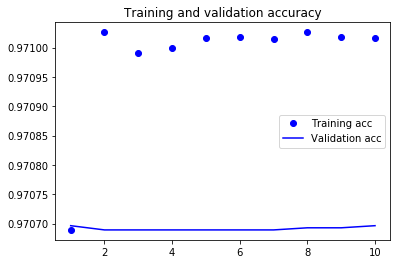

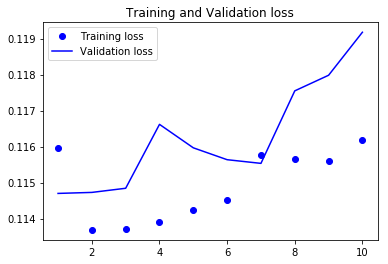

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


## Testing the model on test data

#### Tokenizing the data of the test data set

In [26]:
test_texts = []
test_labels = []
test_id = []

with open('./data/test.csv') as test_file:
    reader = csv.DictReader(test_file)
    for row in reader:
        test_texts.append(row['comment_text'])
        test_id.append(row['id'])

test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=maxlen)


In [27]:
test_labels = model.predict(x_test)

In [28]:
print(test_labels[:10])

[[  9.00747478e-01   4.25946787e-02   8.80049635e-03   3.84937935e-02
    1.32611131e-05   1.31986095e-02   3.93249938e-05]
 [  9.20832574e-01   2.20005848e-02   1.48388068e-03   2.27850210e-02
    1.91895580e-07   1.83757965e-03   1.08979498e-06]
 [  9.00226176e-01   4.28805947e-02   8.69227387e-03   3.83023396e-02
    1.31976030e-05   1.29983081e-02   3.78885998e-05]
 [  9.00883496e-01   4.24214788e-02   8.74556135e-03   3.83557193e-02
    1.31868082e-05   1.31069850e-02   3.90418281e-05]
 [  8.98803949e-01   4.37018611e-02   9.21383966e-03   3.93217094e-02
    1.43812567e-05   1.41347684e-02   4.30692562e-05]
 [  9.00884032e-01   4.24229614e-02   8.74572340e-03   3.83565538e-02
    1.31865318e-05   1.31066525e-02   3.90429486e-05]
 [  9.00876999e-01   4.24236804e-02   8.74452479e-03   3.83597538e-02
    1.31855249e-05   1.31051578e-02   3.90388886e-05]
 [  9.52008963e-01   5.34925051e-03   1.76900241e-04   1.18238237e-02
    5.12545775e-08   4.03296202e-04   1.72543778e-07]
 [  9.00

In [29]:
print(test_labels.shape)
print(len(test_texts))

(153164, 7)
153164


### save the test out in file

In [30]:
# same the labels only as csv
np.savetxt('./test_labels_out.csv', test_labels, delimiter=',', fmt='%f')

In [31]:
# save the test labels with id
test_pred_out = []
with open('test-result.csv', 'w') as f:
    f.write("id,toxic,severe_toxic,obscene,threat,insult,identity_hate\n")
    for i in range(0, len(test_id)):
        #print(i)
        f.write(test_id[i])
        f.write(',')
        #generate an array with strings
        x_arrstr = np.char.mod('%f', test_labels[i, 1:])
        #combine to a string
        x_str = ",".join(x_arrstr)
        f.write(x_str)#,0:])#.tolist))
        f.write('\n')